# Introduction
In this project, we will build a **H&M Personalized Fashion Recommendation system** based on [this kaggle competition](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview ).  

We have 3 datasets at our disposal:
- **articles.csv** - which contains information about the products in the catalog;
- **customers.csv** - which contains information about the customers (customers' information will be not used in the models);
- **transactions.csv**  - which list the purchases of each customer for each date.

In our projects, we will first **explore the three datasets**.

We will then provide **two types of recommendation systems**:
- **Collaborative filtering**, based on the user-item interaction matrix
- **Hybrid model**, based on the user-item interaction matrix and product information.

We will apply these models on the **'menswear' category**, as it seems the one which suits best our limited computation power.

To build our models, we will use [LightFM](https://arxiv.org/pdf/1507.08439.pdf), a python library for recommendation systems implementation.

At the end, we will present our conclusions regarding the comparison of the models we have developed. Additionally, we will give some suggestions for potential improvements.

# 1. Data analysis

Since the transaction_train data is too big (3.49 GB), we will have to take a sample and train our model on that sample.
There are different ways to choose how to make that sample:
- Time: we can take a sample of the data by time ( a certain month/season)
- Users: filter out users who have purchased less than X (for example 5) articles
- Category:
  - Kids clothes
  - Accessories
  - Vests/shorts etc

The data analysis step will help us determine which is the best/most optimal way to sample this data.


### Libraries and Data import

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files

##drive.mount('/content/drive')

In [ ]:
from sklearn import preprocessing

In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808333 sha256=9d16d286b76c67cf86db3fe267557c0fa3c95c48a8c0a25e7332ee15abee3b8b
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k, recall_at_k

In [ ]:
# Import data

!gdown --id 1oRm3wknkR-bYQGNNIZ42HPEB99xLhNJQ
!gdown --id 1zRbd7W0rawaqXe4Tx37-7bZzJjwwXSnT
!gdown --id 1AOK7PX9Uu4GRv2ybv7zWuMNjuXjKn7ll

df_transactions = pd.read_csv('/content/transactions_train.csv')
df_articles = pd.read_csv('/content/articles.csv')
df_customers = pd.read_csv('/content/customers.csv')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1oRm3wknkR-bYQGNNIZ42HPEB99xLhNJQ
To: /content/articles.csv
100% 36.1M/36.1M [00:00<00:00, 88.2MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zRbd7W0rawaqXe4Tx37-7bZzJjwwXSnT
To: /content/transactions_train.csv
100% 3.49G/3.49G [00:38<00:00, 89.6MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.g

## Articles

We will start by analysing the articles dataset.
- What products are the most present
- Category distribution
- Most popular articles/products
- Take one category (swimsuit) and study the evolution on a two year periode

In [ ]:
df_articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


Some of these columns are not useful to us so we will drop them

In [ ]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

Some information are redundant, for that reason

In [ ]:
df_articles = df_articles.astype({'prod_name':'string', 'product_type_name':'string','product_group_name':'string', 'graphical_appearance_name':'string','graphical_appearance_name':'string', 'department_name':'string',
                                  'index_code':'string', 'index_name':'string','index_group_name':'string', 'section_name':'string','garment_group_name':'string', 'detail_desc':'string',
                                  'perceived_colour_value_name':'string', 'perceived_colour_master_name':'string','colour_group_name':'string' })



In [ ]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  string
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  string
 5   product_group_name            105542 non-null  string
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  string
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  string
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  string
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [ ]:
df_articles.nunique()


article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [ ]:
df_articles.query("product_code == 110065").transpose()

,3,4,5
article_id,110065001,110065002,110065011
product_code,110065,110065,110065
prod_name,OP T-shirt (Idro),OP T-shirt (Idro),OP T-shirt (Idro)
product_type_no,306,306,306
product_type_name,Bra,Bra,Bra
product_group_name,Underwear,Underwear,Underwear
graphical_appearance_no,1010016,1010016,1010016
graphical_appearance_name,Solid,Solid,Solid
colour_group_code,9,10,12
colour_group_name,Black,White,Light Beige


<Axes: >

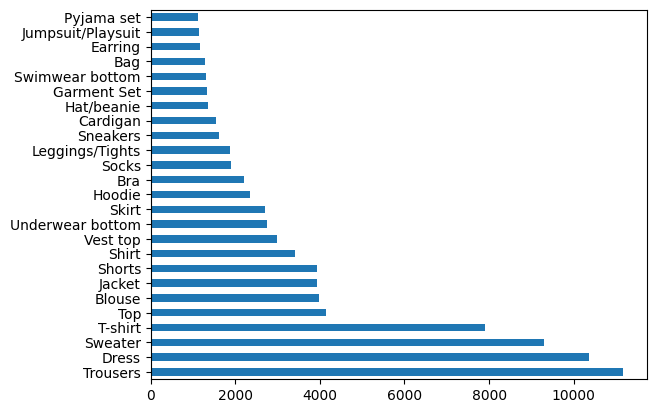

In [ ]:
df_articles['product_type_name'].value_counts()[:25].plot.barh()

<Axes: >

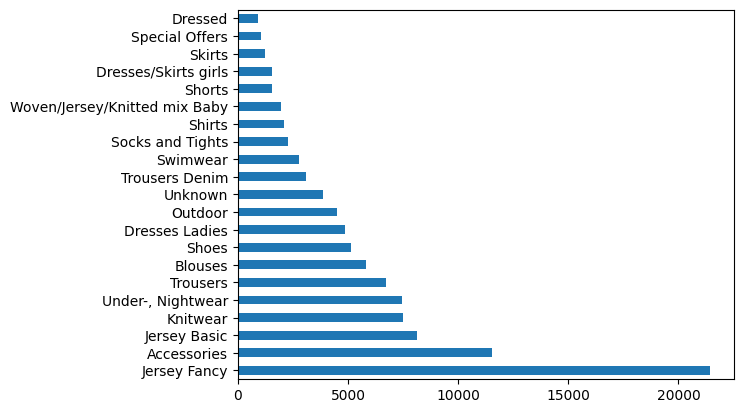

In [ ]:
df_articles['garment_group_name'].value_counts().plot.barh()

<Axes: >

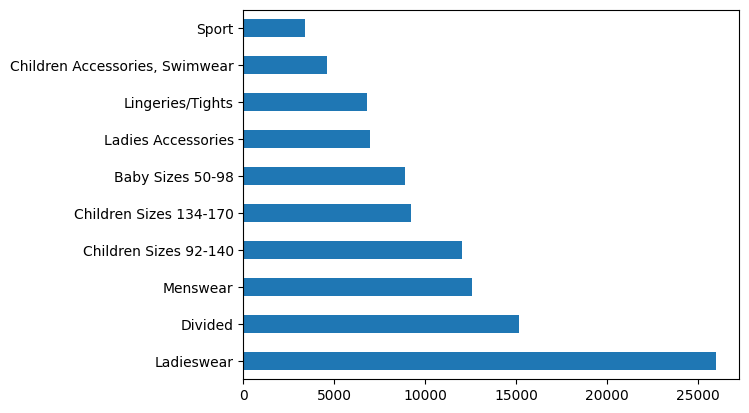

In [ ]:
df_articles['index_name'].value_counts().plot.barh()

<Axes: >

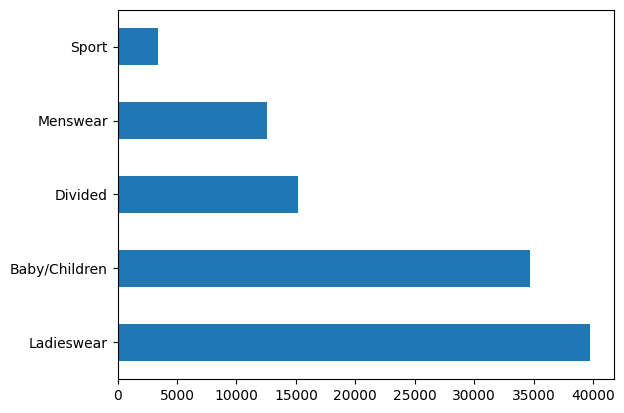

In [ ]:
df_articles['index_group_name'].value_counts().plot.barh()

Using these graphs we can start determinig how are we going to sample our data.
Menswear seems like a good choice for now.

## Customers

In [ ]:
df_customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [ ]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [ ]:
df_customers.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

In [ ]:
df_customers['customer_id'] = df_customers['customer_id'].astype('string')

array([[<Axes: title={'center': 'age'}>]], dtype=object)

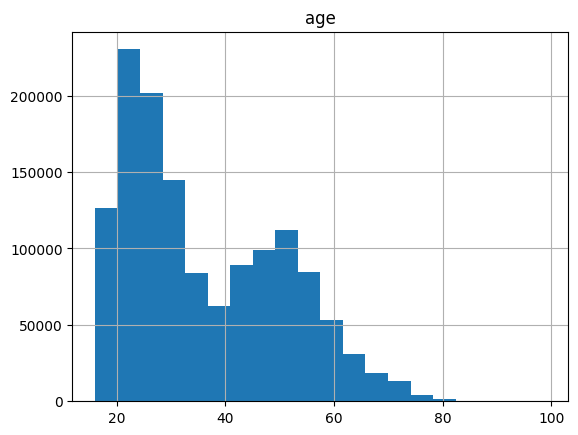

In [ ]:
df_customers.hist(column='age', bins=20)

We can see here that the prominent age group is 20s/30s.

For this dataframe, we will only need the customer_id and possibly the age, so we will drop the rest.

In [ ]:
df_customers = df_customers[['customer_id','age']]

In [ ]:
df_customers['age'].fillna(int(df_customers['age'].mean()), inplace=True)

<ipython-input-22-43a607458667>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customers['age'].fillna(int(df_customers['age'].mean()), inplace=True)


In [ ]:
df_customers.head()

,customer_id,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0


In [ ]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   customer_id  1371980 non-null  string 
 1   age          1371980 non-null  float64
dtypes: float64(1), string(1)
memory usage: 20.9 MB


## Transactions

In [ ]:
df_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


Let's check the date range in our data set, we might use this later for test-train dataset split

In [ ]:
df_transactions['t_dat']= pd.to_datetime(df_transactions['t_dat'])

In [ ]:
(df_transactions["t_dat"].min(), df_transactions["t_dat"].max())

(Timestamp('2018-09-20 00:00:00'), Timestamp('2020-09-22 00:00:00'))

In [ ]:
df_transactions['customer_id']= df_transactions['customer_id'].astype('string')

In [ ]:
df_transactions.nunique()

t_dat                   734
customer_id         1362281
article_id           104547
price                  9857
sales_channel_id          2
dtype: int64

<Axes: ylabel='sales_channel_id'>

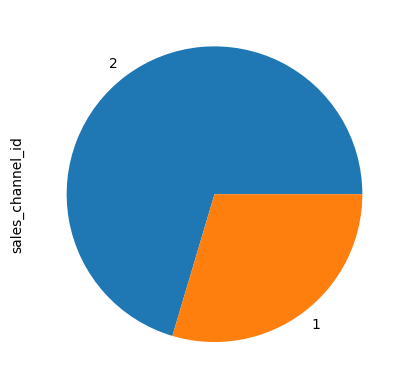

In [ ]:
df_transactions['sales_channel_id'].value_counts().plot(kind='pie')

The majority of transactions are done via channel 2: online.

<Axes: >

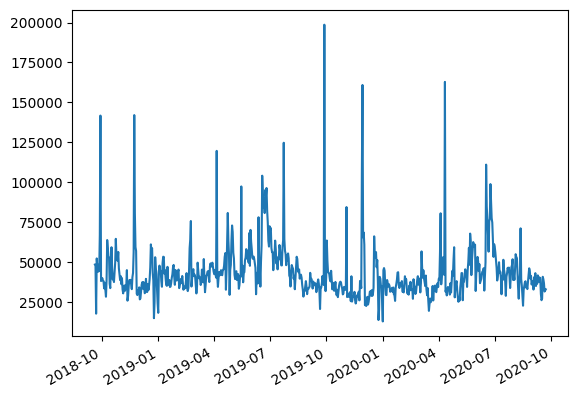

In [ ]:
from matplotlib import pyplot
df_transactions['t_dat'].value_counts().plot()

Let's look at the top 10 users in this shop for the past two years:

In [ ]:
customer_interactions = df_transactions.groupby(['customer_id']).size().reset_index(name='nb_articles').sort_values(by='nb_articles', ascending=False)

In [ ]:
customer_interactions.head(10)

,customer_id,nb_articles
1011710,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,1895
962395,b4db5e5259234574edfff958e170fe3a5e13b6f146752c...,1441
391840,49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05...,1364
885174,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,1361
1090960,cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed...,1237
456062,55d15396193dfd45836af3a6269a079efea339e875eff4...,1208
1028179,c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27c...,1170
755132,8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d...,1169
20162,03d0011487606c37c1b1ed147fc72f285a50c05f00b971...,1157
578832,6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2...,1143


In [ ]:
customer_interactions.tail(10)

,customer_id,nb_articles
1230693,e74c83a32ae911f9e7e51e169fd684ba1153ff309bac77...,1
832211,9c781906abdb54dd9323059c4f6a0e69631b91f7e78c40...,1
832252,9c7a442237f6a2d39b506db6b6792d65f3e7044ba1e73f...,1
1230696,e74cdd29abc3338c682c38e3a25022eadae674a555deda...,1
234328,2c0f1851183f0408dc3c6b2c1cd7a6ded6eb2fa3e4bf8b...,1
832233,9c7945de9cd5a5d7f833476ee2d7739e82b180a2026b5c...,1
234335,2c0f5a51c0b29188a119bdd358897f279b1dda4ba0194b...,1
234337,2c0f6e18e2e825f006126fc8be1117928fa24d5810857a...,1
832215,9c784d9b315f5c761a2f6c267f88d7f9bb4d8597b7983f...,1
1362280,ffffd9ac14e89946416d80e791d064701994755c3ab686...,1


In [ ]:
customer_interactions.describe()

,nb_articles
count,1.362281e+06
mean,2.333463e+01
std,3.924225e+01
min,1.000000e+00
25%,3.000000e+00
50%,9.000000e+00
75%,2.700000e+01
max,1.895000e+03


In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       string        
 2   article_id        int64         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), string(1)
memory usage: 1.2 GB


<Axes: >

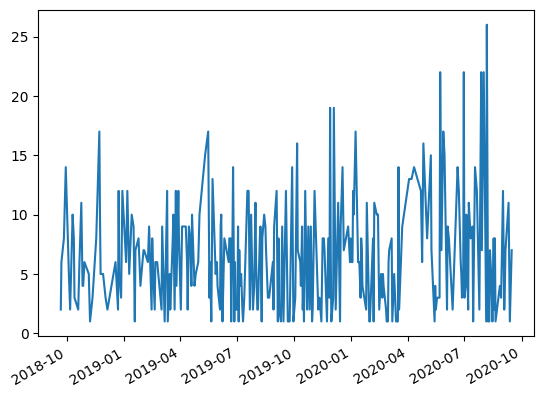

In [ ]:
df_transactions.query("customer_id == 'be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b' ")['t_dat'].value_counts().plot()

We will remove users who bought less than 9 articles.

In [ ]:
customer_interactions = customer_interactions [customer_interactions['nb_articles'] >= 9]

Now we will check the articles and take ones who are at least bought N times (N will be defined based on the statistcs below)


In [ ]:
article_interactions = df_transactions.groupby(['article_id']).size().reset_index(name='nb_buyers').sort_values(by='nb_buyers', ascending=False)

In [ ]:
article_interactions.head()

,article_id,nb_buyers
53832,706016001,50287
53833,706016002,35043
1711,372860001,31718
24808,610776002,30199
70124,759871002,26329


In [ ]:
article_interactions.describe()

,article_id,nb_buyers
count,1.045470e+05,104547.000000
mean,6.968200e+08,304.057735
std,1.277177e+08,791.266060
min,1.087750e+08,1.000000
25%,6.161290e+08,14.000000
50%,7.010500e+08,65.000000
75%,7.945750e+08,286.000000
max,9.562170e+08,50287.000000


In [ ]:
article_interactions = article_interactions [article_interactions['nb_buyers'] >= 65]

# 2. Data sampling and preparation

## Data sampling and Data split

We will split the transactions data into transactions which took place prior to June 2020, as a training set, and transactions which took place after June 2020, as a test set.

In [ ]:
df_transactions_test = df_transactions.query("t_dat >= '2020-06-22 00:00:00'")
df_transactions_train = df_transactions.query("t_dat < '2020-06-22 00:00:00'")

In [ ]:
df_transactions_test.count()

t_dat               4056792
customer_id         4056792
article_id          4056792
price               4056792
sales_channel_id    4056792
dtype: int64

In [ ]:
df_transactions_train.count()

t_dat               27731532
customer_id         27731532
article_id          27731532
price               27731532
sales_channel_id    27731532
dtype: int64

Since this still is a lot of data and we don't have a lot of computation power, we will only take a sample to train our model on. After the data analysis, Menswear seems like a good sampling criteria.

In [ ]:
articles_sample = df_articles.query("index_group_name == 'Menswear'")
transactions_sample =  df_transactions.join(articles_sample[['article_id']].set_index('article_id'), on= 'article_id', how= "inner")

In [ ]:
articles_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12553 entries, 16 to 105537
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   article_id                    12553 non-null  int64 
 1   product_code                  12553 non-null  int64 
 2   prod_name                     12553 non-null  string
 3   product_type_no               12553 non-null  int64 
 4   product_type_name             12553 non-null  string
 5   product_group_name            12553 non-null  string
 6   graphical_appearance_no       12553 non-null  int64 
 7   graphical_appearance_name     12553 non-null  string
 8   colour_group_code             12553 non-null  int64 
 9   colour_group_name             12553 non-null  string
 10  perceived_colour_value_id     12553 non-null  int64 
 11  perceived_colour_value_name   12553 non-null  string
 12  perceived_colour_master_id    12553 non-null  int64 
 13  perceived_colo

In [ ]:
transactions_sample.count()

t_dat               1771053
customer_id         1771053
article_id          1771053
price               1771053
sales_channel_id    1771053
dtype: int64

In [ ]:
df_transactions.count()

t_dat               31788324
customer_id         31788324
article_id          31788324
price               31788324
sales_channel_id    31788324
dtype: int64

<Axes: >

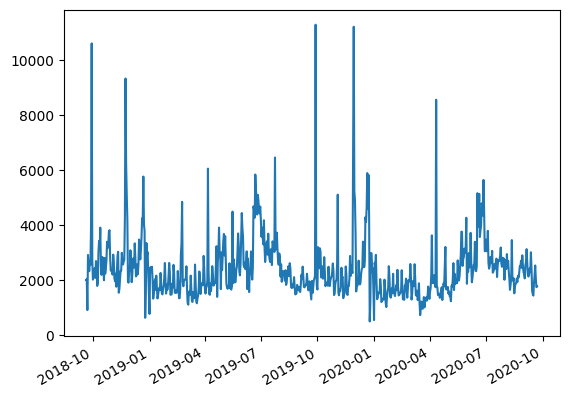

In [ ]:
transactions_sample['t_dat'].value_counts().plot()

In [ ]:
df_transactions_sample_test = transactions_sample.query("t_dat >= '2020-06-22 00:00:00'")
df_transactions_sample_train = transactions_sample.query("t_dat < '2020-06-22 00:00:00'")

In [ ]:
df_transactions_sample_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240741 entries, 28071103 to 31785950
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   t_dat             240741 non-null  datetime64[ns]
 1   customer_id       240741 non-null  string        
 2   article_id        240741 non-null  int64         
 3   price             240741 non-null  float64       
 4   sales_channel_id  240741 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), string(1)
memory usage: 11.0 MB


In [ ]:
df_transactions_sample_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1530312 entries, 44 to 27717329
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1530312 non-null  datetime64[ns]
 1   customer_id       1530312 non-null  string        
 2   article_id        1530312 non-null  int64         
 3   price             1530312 non-null  float64       
 4   sales_channel_id  1530312 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), string(1)
memory usage: 70.1 MB


Keep only active buyers and articles:

In [ ]:
##df_transactions_sample_train = df_transactions_sample_train[df_transactions_sample_train["customer_id"].isin(customer_interactions.index) & df_transactions_sample_train["article_id"].isin(article_interactions.index)]
df_transactions_sample_train = df_transactions_sample_train.join(customer_interactions[['customer_id']].set_index('customer_id'), on= 'customer_id', how= "inner").join(article_interactions[['article_id']].set_index('article_id'), on= 'article_id', how= "inner")

In [ ]:
df_transactions_sample_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293882 entries, 44 to 27581027
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1293882 non-null  datetime64[ns]
 1   customer_id       1293882 non-null  string        
 2   article_id        1293882 non-null  int64         
 3   price             1293882 non-null  float64       
 4   sales_channel_id  1293882 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), string(1)
memory usage: 59.2 MB


## Data Preparation


When using the LightFM library, the first step involves creating a sparse matrix known as the **user-item interaction matrix**. In the case of hybrid collaborative-content recommendation, we can also use **item-feature matrix**.

The **user-item interaction** **matrix** is responsible for representing interactions between users (customers) and items (articles). In this scenario, where explicit ratings are unavailable, we can use implicit signals instead. For example, the number of times a customer purchases a product can serve as an implicit rating. If customer A bought article B ten times, it implies that customer A rates article B with a rating of 10. Alternatively, binary ratings can be employed, where 1 indicates a purchase, and 0 signifies no purchase. This user-item interaction matrix captures the collaborative filtering aspect of the model.

On the other hand, the **item-feature interaction matrix** describes the features of the items. It establishes a link between articles and their metadata, such as their group, departmenet, section, or other relevant information. If article A is belongs to group B, then the element in the matrix corresponding to article A and group B would be 1, and 0 otherwise. This matrix introduces content-based contributions to the model.

### User-item interaction matrix

Constructing a user-item interaction matrix. We need to take into account that LightFM library can only read a sparse coo matrix, can be constructed using coo_matrix from scipy.sparse , in which we need to convert the article_id into integer index . Therefore, we built the user-item interaction matrix with converted customer_id into index representing the row of the matrix and into indexes as the column. And also not forgetting about creating dictionary mappings for customer_id to index, index to customer_id, article_id to index, and index to article_id.

In [ ]:
user_item = df_transactions_sample_train.groupby(['customer_id', 'article_id']).size().reset_index(name='rating')

In [ ]:
##user_item_test = df_transactions_sample_test.groupby(['customer_id', 'article_id']).size().reset_index(name='rating')

In [ ]:
user_item.sort_values(by = 'rating', ascending = False).head(10)

,customer_id,article_id,rating
1036641,ef38ec0f0cb29ee8bbb87efc82fd16f4b99127e3eeefe6...,570002001,170
895922,ce79a54991bb7c2c2d9427ae1e7f1d8c8b037f8d74b2fe...,570004009,124
730987,a81e0b7657a090198d8138c95fae7db1218305b97bb8fd...,618480001,100
1044531,f11ddea20db46fd5f005b6bb0ec4b083f6765d2b03e241...,557247001,86
728279,a77ced28f1ca69f3a154cee61b42bbf4933ed483f1d515...,685816002,76
423887,61da44a2758206d5701771f4315637b40c8321b5111916...,501616007,70
726145,a6f23def84decb02af89ae94c44c1c61a2bf3462ca90df...,669091001,62
226710,34305a3f35f423cdc5ebceeea8286b2a1136538b4a4b52...,685816002,56
519131,77c5a91b2849b719bd7465f9a46fc587d947a963a55eb2...,685816001,53
957212,dc7d629fe0609b3f9b52e054aa97639263b8cd204ec627...,557248001,52


In [ ]:
user_item.describe()

,article_id,rating
count,1.109381e+06,1.109381e+06
mean,6.421357e+08,1.166310e+00
std,1.153724e+08,7.311389e-01
min,1.184580e+08,1.000000e+00
25%,5.700020e+08,1.000000e+00
50%,6.715990e+08,1.000000e+00
75%,7.171960e+08,1.000000e+00
max,9.054010e+08,1.700000e+02


In [ ]:
df_articles[df_articles['article_id']==570002001]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
16452,570002001,570002,ROY SLIM RN T-SHIRT,255,T-shirt,Garment Upper body,1010016,Solid,9,Black,...,Light Basic Jersey,F,Menswear,3,Menswear,26,Men Underwear,1002,Jersey Basic,Round-necked T-shirt in soft jersey.


# 3. Collaborative Filtering

The problem with the initial data splitting is that it does not work with pure collaborative filtering. Since it can't tackle the cold-start problem (make a recommendation for a new user), therefore, the train and test split must be done so instances of customers or articles in the testing set must have remaining instances in the training set:





## Data Preparation for pure CF

In [ ]:
train_ratio = 0.8
user_item = user_item.sample(frac = 1).reset_index(drop = True)
split_cut = int(np.round(user_item.shape[0] * train_ratio))
user_item_train = user_item.iloc[0:split_cut]
user_item_test = user_item.iloc[split_cut::]
user_item_test = user_item_test[(user_item_test['customer_id'].isin(user_item_train['customer_id']))& (user_item_test['article_id'].isin(user_item_train['article_id']))]

train = dict()
test = dict()
encoder = dict()
for k in ('customer_id', 'article_id'):
    le = preprocessing.LabelEncoder()
    train[k] = le.fit_transform(user_item_train[k].values)
    test[k] = le.transform(user_item_test[k].values)
    encoder[k] = le

train['rating'] = user_item_train['rating']
test['rating'] = user_item_test['rating']

users = np.unique(train['customer_id'])
items = np.unique(train['article_id'])

rate_matrix = dict()
rate_matrix['train'] = coo_matrix((train['rating'],
                                    (train['customer_id'],
                                    train['article_id'])),
                                  shape = (len(users), len(items) ))

rate_matrix['test'] = coo_matrix((test['rating'],
                                  (test['customer_id'],
                                    test['article_id'])),
                                  shape = (len(users), len(items) ))

## Light FM Model

In [ ]:
cf_model = LightFM(loss = 'warp',
                   no_components = 150,
                   learning_rate = 0.02)

cf_model.fit(rate_matrix['train'], epochs = 50, num_threads = 4)


## Evalution

We will employ **different evaluation metrics** for our recommendation system model: the Area Under the ROC Curve (AUC),  Precision and Recall at K.


**AUC** shows the likelihood that a randomly chosen relevant item is positioned higher than an irrelevant one. A higher likelihood of this occurrence translates to a superior AUC score, indicating a more effective recommendation system.
This evaluation metric is suitable in cases where we are interested in ranking items rather than providing a fixed number of recommendations.


**Precision and recall at K** measure the quality of the top-k recommendations by focusing on how many of the recommended items are relevant to the user.
- Precision at k measures the proportion of the top-k recommended items that are actually relevant to the user. It's sensitive to the order and relevance of the top-k items.
- Recall at k measures the proportion of relevant items that are included in the top-k recommendations. It provides insights into how well the model captures all relevant items.

These evaluation metrics are suitable in cases where we are interested in providing a fixed number of recommendations.

In [ ]:
#AUC
auc_train = auc_score(cf_model, rate_matrix['train']).mean()
auc_test = auc_score(cf_model, rate_matrix['test']).mean()

print(f"Collaborative RS model - AUC train and test: {auc_train * 100:.2f}%, {auc_test * 100:.2f}%")

Collaborative RS model - AUC train and test: 99.98%, 85.02%


In [ ]:
# Precision & recall consider a certain number of items (k)
k = 5
precision_K = precision_at_k(cf_model, rate_matrix['test'], k=k).mean()
recall_k = recall_at_k(cf_model, rate_matrix['test'], k=k).mean()

print(f"Collaborative RS model - Precision/recall at k = 5: {precision_K * 100:.2f}%, {recall_k  * 100:.2f}%")

Collaborative RS model - Precision/recall at k = 5: 2.03%, 6.83%


# Hybrid method

Another approach to recommendation systems is to use a **hybrid method** which combines from one side collaborative filtering and from the other content-based filtering.
We have already discussed collaborative filtering in the previous paragraph.
Content-based filtering is conceived around the idea of recommending products that are similar to the ones that users like based on their previous actions (eg. purchase) or explicit feedback. Similarity can be assessed, for example, by considering product descriptions and features.

The hybrid approach **aims at getting better results than the use of a single approach overcoming their respective limitations**: the cold-start problem (referring to newly-introduced products) for collaborative filtering and the overspecializations (lack of diversity among the recommended items) for content-based filtering.

In this section we will apply the hybrid approach to the 'menswear category' and evaluate its performance. A model comparison will be provided in the conclusion paragraph of this project.

### Item-feature matrix

In order to prepare the data to create our item-feature matrix, we need to select the features we want to take into account and encode them if they are categorical. In our example, we'll select the "section name" and "color group". To reduce the number of encoded columns, we'll group colors together (for example, light and dark colors in a single color group) and select only the most common section names.

In [ ]:
#create df with only articles we will use in our model
df_articles_men = user_item[['article_id']].merge(df_articles, on='article_id', how='left').drop_duplicates()

In [ ]:
#get the item feature list
df_articles_men.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [ ]:
#check number of unique values for each feature in order to select the most suitable one for encoding
df_articles_men.nunique()

article_id                      5510
product_code                    1720
prod_name                       1851
product_type_no                   52
product_type_name                 52
product_group_name                11
graphical_appearance_no           27
graphical_appearance_name         27
colour_group_code                 47
colour_group_name                 47
perceived_colour_value_id          7
perceived_colour_value_name        7
perceived_colour_master_id        18
perceived_colour_master_name      18
department_no                     58
department_name                   43
index_code                         1
index_name                         1
index_group_no                     1
index_group_name                   1
section_no                        13
section_name                      13
garment_group_no                  16
garment_group_name                16
detail_desc                     1587
dtype: int64

In [ ]:
df_articles_men["product_group_name"].value_counts()

Garment Upper body    3206
Garment Lower body    1201
Accessories            331
Socks & Tights         232
Underwear              214
Swimwear               152
Shoes                   95
Nightwear               58
Unknown                 18
Bags                     2
Items                    1
Name: product_group_name, dtype: Int64

In [ ]:
df_type_count = df_articles_men["product_type_name"].value_counts().reset_index()
df_type_count.columns = ["product_type_name", "count"]
df_type_count

,product_type_name,count
0,Trousers,811
1,T-shirt,801
2,Sweater,790
3,Shirt,730
4,Shorts,390
5,Hoodie,272
6,Socks,232
7,Underwear bottom,209
8,Polo shirt,192
9,Swimwear bottom,152


In [ ]:
# get all product types that occur more than 50 times
prod_type_50 = []
for i in range(len(df_type_count)):
  if df_type_count.iloc[i,1] > 50:
    prod_type_50.append(df_type_count.iloc[i,0])
prod_type_50

['Trousers',
 'T-shirt',
 'Sweater',
 'Shirt',
 'Shorts',
 'Hoodie',
 'Socks',
 'Underwear bottom',
 'Polo shirt',
 'Swimwear bottom',
 'Jacket',
 'Blazer',
 'Vest top',
 'Top',
 'Cardigan']

In [ ]:
# I want to create a new column that will be my feature for the hybrid RS
# It will take the product type if it occurs more than 50 times,
# if not, I will consider the product_group_name
# I do this to reduce number of possible values

new_groups = []

# replace product type by product group if it occurs less than 50 time (this means is not in the list we created)
for i in range(len(df_articles_men)):
  if df_articles_men.iloc[i]["product_type_name"] in prod_type_50:
    new_groups.append(df_articles_men.iloc[i]["product_type_name"])
  else:
    new_groups.append(df_articles_men.iloc[i]["product_group_name"])

In [ ]:
# add the new column
df_articles_men["product_type_NEW"] = new_groups
# check value of new column
df_articles_men["product_type_NEW"].value_counts()

Trousers              811
T-shirt               801
Sweater               790
Shirt                 730
Shorts                390
Accessories           331
Hoodie                272
Socks                 232
Underwear bottom      209
Polo shirt            192
Swimwear bottom       152
Jacket                122
Shoes                  95
Blazer                 72
Vest top               69
Top                    63
Nightwear              58
Cardigan               51
Garment Upper body     44
Unknown                18
Underwear               5
Bags                    2
Items                   1
Name: product_type_NEW, dtype: int64

In [ ]:
#further group some categories
def color_fun(x):
  if x == "Underwear bottom":
    return "Underwear"
  elif x == "Bags":
    return "Accessories"
  elif x == "Items":
    return "Accessories"
  else:
    return x

df_articles_men["product_type_NEW2"] = df_articles_men["product_type_NEW"].apply(color_fun)
df_articles_men["product_type_NEW2"].value_counts()

Trousers              811
T-shirt               801
Sweater               790
Shirt                 730
Shorts                390
Accessories           334
Hoodie                272
Socks                 232
Underwear             214
Polo shirt            192
Swimwear bottom       152
Jacket                122
Shoes                  95
Blazer                 72
Vest top               69
Top                    63
Nightwear              58
Cardigan               51
Garment Upper body     44
Unknown                18
Name: product_type_NEW2, dtype: int64

In [ ]:
#encode categorical features
from sklearn.preprocessing import OneHotEncoder
features_to_encode = ['product_type_NEW2']
subset_df = df_articles_men[features_to_encode]
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(subset_df)
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(features_to_encode)).drop('product_type_NEW2_Unknown', axis=1)
encoded_articles_men = pd.concat([df_articles_men["article_id"].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis = 1)
encoded_articles_men.head()

,article_id,product_type_NEW2_Accessories,product_type_NEW2_Blazer,product_type_NEW2_Cardigan,product_type_NEW2_Garment Upper body,product_type_NEW2_Hoodie,product_type_NEW2_Jacket,product_type_NEW2_Nightwear,product_type_NEW2_Polo shirt,product_type_NEW2_Shirt,product_type_NEW2_Shoes,product_type_NEW2_Shorts,product_type_NEW2_Socks,product_type_NEW2_Sweater,product_type_NEW2_Swimwear bottom,product_type_NEW2_T-shirt,product_type_NEW2_Top,product_type_NEW2_Trousers,product_type_NEW2_Underwear,product_type_NEW2_Vest top
0,669562001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,615304013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,575347010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,701134004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,686564003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data preparation

In [ ]:
# reindex dataframe to match the ordering of items in the 'train' and 'test' data.
item_features_df = encoded_articles_men.reindex(index=items)

In [ ]:
# sparse matrix
item_features_matrix = coo_matrix(item_features_df.drop('article_id', axis=1).values)

## LightFM Model

In [ ]:
hm_model = LightFM(loss = 'warp',
                no_components = 150,
                learning_rate = 0.02,
                # adding regularization to prevent overfitting:
                user_alpha=0.0001,
                item_alpha=0.00001)

hm_model.fit(rate_matrix['train'], item_features = item_features_matrix, epochs = 50, num_threads = 4)

## Evaluation

We will evaluate the model using the same methods we explained in the collaborative filtering part.

In [ ]:
# AUC
hm_auc_train = auc_score(hm_model, rate_matrix['train'], item_features = item_features_matrix).mean()
hm_auc_test = auc_score(hm_model, rate_matrix['test'], item_features = item_features_matrix).mean()
hm_auc_train, hm_auc_test
print(f"Hybrid RS model - AUC train and test: {hm_auc_train * 100:.2f}%, {hm_auc_test * 100:.2f}%") #Result without regularization and no_components=150 was 84.20%, 45.92%

Hybrid RS model - AUC train and test: 84.20%, 45.47%


#  Conclusion

In this project we developed two recommendation systems: one based on collaborative filtering, the other on a hybrid method which considers not only user interactions but also product features.

Comparing the two models performance, the hybrid method obtained a lower score than the collaborative filtering one (respectively AUC score 0.45 vs. 0.85).


The lower performance of the hybrid method may be explained by several factors that should be further investigated and tested for improving the model. One could be related to feature selection and engineering, since the success of a hybrid system can heavily depend on the quality and relevance of the features used in the content-based part. In our example we used 'product type' but other item features could be added in the model and tested.


Furthermore, improvements on both models may include hyperparameter tuning, such as: the number of latent factors (no_components), the learning rate schedule (learning_schedule), the loss function to be optimized (loss) and the regularization strengths to prevent overfitting (L2 penalty on user or item features: item_alpha, user_alpha).